# 一、项目介绍

## 1. 项目背景/意义：
MNIST是一个手写体数字的图片数据集，该数据集来由美国国家标准与技术研究所（National Institute of Standards and Technology (NIST)）发起整理，一共统计了来自250个不同的人手写数字图片，其中50%是高中生，50%来自人口普查局的工作人员。   
该数据集的收集目的是希望通过算法，实现对手写数字的识别。

## 2. 项目拟使用的方法：
使用经典Lenet模型学习深度学习框架搭建，了解卷积层、激活层、池化层、全连接层的用法和意义，主要采用paddle.nn库完成模型。

## 3. 项目数据集
选择（[经典MNIST数据集](https://aistudio.baidu.com/aistudio/datasetdetail/65)）数据集，数据集地址：https://aistudio.baidu.com/aistudio/datasetdetail/65

# 二、数据处理

## 1. 数据集清洗与介绍：
挂载MNIST数据集，gzip解压数据集，tree/ls命令查看目录结构

In [1]:
# 使用gzip命令解压数据集文件
!gzip -dfq data/data65/t10k-labels-idx1-ubyte.gz
!gzip -dfq data/data65/train-labels-idx1-ubyte.gz
!gzip -dfq data/data65/t10k-images-idx3-ubyte.gz
!gzip -dfq data/data65/train-images-idx3-ubyte.gz

# 使用tree/ls命令查看目录结构
!tree data/data65 -d
!ls data/data65

gzip: data/data65/t10k-labels-idx1-ubyte.gz: No such file or directory
gzip: data/data65/train-labels-idx1-ubyte.gz: No such file or directory
gzip: data/data65/t10k-images-idx3-ubyte.gz: No such file or directory
gzip: data/data65/train-images-idx3-ubyte.gz: No such file or directory
data/data65

0 directories
t10k-images-idx3-ubyte	train-images-idx3-ubyte
t10k-labels-idx1-ubyte	train-labels-idx1-ubyte


## 2. 数据集类的定义：
自定义MyMNISTDataset类继承paddle.io.Dataset，并实现\_\_init\_\_, \_\_getitem\_\_，\_\_len\_\_方法，decode_idx3_ubyte和decode_idx1_ubyte方法分别完成图片和标签文件的解码，并返回numpy格式的图片数据和标签数据

In [2]:
# 定义数据集类
import paddle
import numpy as np
import struct

class MyMNISTDataset(paddle.io.Dataset):
    def __init__(self, image_file, label_file):
        super(MyMNISTDataset, self).__init__()
        self.images = self.decode_idx3_ubyte(image_file)
        self.labels = self.decode_idx1_ubyte(label_file)
        self.length = len(self.labels)

    def __getitem__(self, index):
        return self.images[index].astype('float32'), self.labels[index].astype('int64')

    def __len__(self):
        return self.length

    def decode_idx3_ubyte(self, idx3_ubyte_file):
        bin_data = open(idx3_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>iiii'
        magic_number, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, offset)
        image_size = num_rows * num_cols
        offset += struct.calcsize(fmt_header)
        fmt_image = '>' + str(image_size) + 'B'
        images = np.empty((num_images, num_rows, num_cols), dtype=np.uint8)
        for i in range(num_images):
            images[i] = np.array(struct.unpack_from(fmt_image, bin_data, offset)).reshape((num_rows, num_cols))
            offset += struct.calcsize(fmt_image)
        images = np.expand_dims(images, axis=1)
        return images

    def decode_idx1_ubyte(self,idx1_ubyte_file):
        bin_data = open(idx1_ubyte_file, 'rb').read()
        offset = 0
        fmt_header = '>ii'
        magic_number, num_labels = struct.unpack_from(fmt_header, bin_data, offset)
        offset += struct.calcsize(fmt_header)
        fmt_label = '>B'
        labels = np.empty(num_labels, dtype=np.uint8)
        for i in range(num_labels):
            labels[i] = struct.unpack_from(fmt_label, bin_data, offset)[0]
            offset += struct.calcsize(fmt_label)
        labels = np.expand_dims(labels, axis=-1)
        return labels

## 3. 数据集类的测试：
通过MyMNISTDataset类构造训练集和测试集，分别获得样本数据和标签数据，测试get、len方法，并用dataloader封装后测试batch效果

In [3]:
train_dataset = MyMNISTDataset("data/data65/train-images-idx3-ubyte", "data/data65/train-labels-idx1-ubyte")
test_dataset = MyMNISTDataset("data/data65/t10k-images-idx3-ubyte", "data/data65/t10k-labels-idx1-ubyte")

train_dataloader = paddle.io.DataLoader(
    train_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=False)
for step, data in enumerate(train_dataloader):
    image, label = data
    print("训练集batch数据:", step, image.shape, label.shape)
test_dataloader = paddle.io.DataLoader(
    test_dataset,
    batch_size=1024,
    shuffle=True,
    drop_last=False)
for step, data in enumerate(test_dataloader):
    image, label = data
    print("测试集batch数据:", step, image.shape, label.shape)

训练集batch数据: 0 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 1 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 2 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 3 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 4 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 5 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 6 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 7 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 8 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 9 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 10 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 11 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 12 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 13 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 14 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 15 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 16 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 17 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 18 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 19 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 20 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 21 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 22 [1024, 1, 28, 28] [1024, 1]
训练集batch数据: 23 [1024,

## 4. 图像/文本数据的统计分析：
对训练集和测试集的第1个样本进行可视化展示，对训练集和测试集的全量样本，分别进行图片数据整体均值和方差计算

训练集样本大小： 60000
训练集图片大小： (60000, 1, 28, 28)
训练集标签大小： (60000, 1)
训练集第1个样本：
标签数据： [5]
图片：


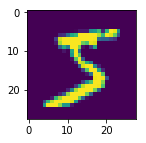


图片数据： [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126
   136 175  26 166 255 247 127   0   0   0   0]
  [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253
   253 225 172 253 242 195  64   0   0   0   0]
  [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253
   251  93  82  82  56  39   0   0   0   0   0]
  [  0   0   0   0   0   0   0  18 219 25

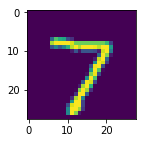


图片数据： [[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0  84 185 159 151  60  36   0   0   0   0   0
     0   0   0   0   0   0   0   0   0   0   0]
  [  0   0   0   0   0   0 222 254 254 25

In [9]:
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")
print("训练集样本大小：", len(train_dataset))
print("训练集图片大小：", train_dataset.images.shape)
print("训练集标签大小：", train_dataset.labels.shape)
print("训练集第1个样本：\n标签数据：", train_dataset.labels[0])
print("图片：")
plt.figure(figsize=(2,2))
plt.imshow(train_dataset.images[0].reshape([28,28]))
plt.pause(1)
print("\n图片数据：", train_dataset.images[0])
print("测试集样本大小：", len(test_dataset))
print("测试集图片大小：", test_dataset.images.shape)
print("测试集标签大小：", test_dataset.labels.shape)
print("测试集第1个样本：\n标签数据：", test_dataset.labels[0])
print("图片：")
plt.figure(figsize=(2,2))
plt.imshow(test_dataset.images[0].reshape([28,28]))
plt.pause(1)
print("\n图片数据：", test_dataset.images[0])

# 三、选择模型

手写字体识别模型LeNet5诞生于1994年，是最早的卷积神经网络之一。LeNet5通过巧妙的设计，利用卷积、参数共享、池化等操作提取特征，避免了大量的计算成本，最后再使用全连接神经网络进行分类识别，这个网络也是最近大量神经网络架构的起点。

In [5]:
# 搭建Lenet5模型
import paddle.nn as nn
import paddle.nn.functional as F

class Lenet(nn.Layer):
    def __init__(self):
        super(Lenet, self).__init__()
        self.conv1 = nn.Conv2D(1, 6, 5)
        self.pool1 = nn.MaxPool2D(2, 2)
        self.conv2 = nn.Conv2D(6, 16, 5)
        self.pool2 = nn.MaxPool2D(2, 2)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = paddle.flatten(x, start_axis=1, stop_axis=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # 原LeNet采用径向基函数（RBF）的网络连接方式，参数需根据先验知识固定，这里简化为线性层连接
        return x

# 四、模型训练

首先定义lr，optimize，epoch，batch_size，Loss function等模型参数，使用model.prepare和model.fit进行模型训练



In [6]:
# 定义模型参数
from paddle.optimizer import Adam

lr = 0.001

model = paddle.Model(Lenet())
opt = Adam(learning_rate=lr, parameters=model.parameters())

epoch = 10

batch_size = 64

loss = nn.CrossEntropyLoss()

model.prepare(
    optimizer=opt,
    loss=loss,
    metrics=paddle.metric.Accuracy())

In [7]:
# 模型训练
model.fit(train_dataset,
          epochs=epoch,
          batch_size=batch_size,
          save_dir='my_mnist_model',
          verbose=1)

The loss value printed in the log is the current step, and the metric is the average value of previous steps.
Epoch 1/10
step 938/938 [==============================] - loss: 0.5796 - acc: 0.8579 - 14ms/step         
save checkpoint at /home/aistudio/my_mnist_model/0
Epoch 2/10
step 938/938 [==============================] - loss: 0.3490 - acc: 0.9361 - 14ms/step        
save checkpoint at /home/aistudio/my_mnist_model/1
Epoch 3/10
step 938/938 [==============================] - loss: 0.0019 - acc: 0.9536 - 13ms/step         
save checkpoint at /home/aistudio/my_mnist_model/2
Epoch 4/10
step 938/938 [==============================] - loss: 0.1446 - acc: 0.9634 - 14ms/step        
save checkpoint at /home/aistudio/my_mnist_model/3
Epoch 5/10
step 938/938 [==============================] - loss: 0.2844 - acc: 0.9697 - 14ms/step        
save checkpoint at /home/aistudio/my_mnist_model/4
Epoch 6/10
step 938/938 [==============================] - loss: 0.0212 - acc: 0.9741 - 14ms/step      

# 五、模型测试

使用上一步骤训练完成的LeNet5模型，对测试集数据进行预测，并使用acc_score进行准确性评分。

Predict begin...
step 10000/10000 [==============================] - 2ms/step        
Predict samples: 10000
测试集第1个样本标签为:  7 	 预测值为： 7


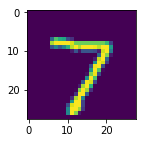

测试集第2个样本标签为:  2 	 预测值为： 2


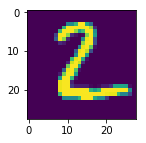

测试集第3个样本标签为:  1 	 预测值为： 1


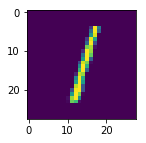

测试集第4个样本标签为:  0 	 预测值为： 0


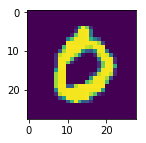

测试集第5个样本标签为:  4 	 预测值为： 4


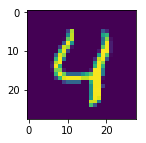

模型在测试集上准确率为：97.85%


In [10]:
# 测试模型

import numpy as np
from sklearn.metrics import accuracy_score

preds = model.predict(test_dataset)[0]
preds = list(str(np.argmax(pred)) for pred in preds)
test_labels = list(str(data[1][0]) for data in test_dataset)

for i in range(5):
    print(f'测试集第{i + 1}个样本标签为: ', test_labels[i], '\t', '预测值为：', preds[i])
    plt.figure(figsize=(2,2))
    plt.imshow(test_dataset[i][0].reshape([28,28]))
    plt.pause(1)

acc_score = accuracy_score(test_labels, preds)
print('模型在测试集上准确率为：%.2f%%' % (acc_score * 100))

# 六、个人总结

零基础入门MNIST手写数字识别，非常适合作为CV领域的入门项目。搭积木的过程比结果更重要，实践才是将知识转化为技能的重要途径。

aistudio链接：https://aistudio.baidu.com/aistudio/projectdetail/3529271

github链接：https://github.com/Leocosmosa/-AI-MNIST-

gitee链接：https://gitee.com/Leocosmosa/AI-MNIST